# Introduction- importing all the necessary packages

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from bs4 import BeautifulSoup
import lxml
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                       

Importing database of price data for Brussels communes (districts) from the publicly available sources. To simplify the process, I have already pre-processed the data, translated from French to English and put in the form of csv file. The original data is found on the following website: 
https://statbel.fgov.be/fr/open-data?category=66

In [24]:
url = "https://raw.githubusercontent.com/zamis1/Coursera_Capstone/master/Bruxelles_communes.csv"
stations_df = pd.read_csv(url)
stations_df

,Type,Country,Commune,Postal index,Price
0,Apartments,Belgium,Anderlecht,1070,1940
1,Apartments,Belgium,Auderghem,1160,3130
2,Apartments,Belgium,Berchem-Sainte-Agathe,1082,2040
3,Apartments,Belgium,Bruxelles,1000,2790
4,Apartments,Belgium,Etterbeek,1040,2940
5,Apartments,Belgium,Evere,1140,2610
6,Apartments,Belgium,Vorst,1190,2520
7,Apartments,Belgium,Ganshoren,1083,2040
8,Apartments,Belgium,Ixelles,1050,3380
9,Apartments,Belgium,Jette,1090,1880


## I used gelocator and developed a function 'get_latitude' to automatically locate the district coordinates

In [25]:
geolocator = Nominatim(user_agent="be_explorer")
def get_latitude (address, timeout=5):
    """
    Geolocate an address.

    Returns the latitude and longitude of the given address using
    OpenStreetMap's Nominatim service. If the coordinates of the
    address cannot be found then ``(None, None)`` is returned.

    As per Nominatim's terms of service this function is rate limited
    to at most one call per second.

    ``timeout`` gives the timeout in seconds.
    """
    location = geolocator.geocode(address, timeout=timeout)
    if not location:
        return None, None
    return location.latitude 

def get_longitude (address, timeout=5):
    location = geolocator.geocode(address, timeout=timeout)
    if not location:
        return None, None
    return location.longitude 

def get_coordinates (address, timeout=5):
    location = geolocator.geocode(address, timeout=timeout)
    if not location:
        return None, None
    return location.latitude, location.longitude 

stations_df['Latitude'] = stations_df['Commune'].apply(get_latitude)
stations_df['Longitude'] = stations_df['Commune'].apply(get_longitude)

stations_df['Coordinates']=stations_df['Commune'].apply(get_coordinates)
stations_df

,Type,Country,Commune,Postal index,Price,Latitude,Longitude,Coordinates
0,Apartments,Belgium,Anderlecht,1070,1940,50.839098,4.329653,"(50.8390983, 4.3296526)"
1,Apartments,Belgium,Auderghem,1160,3130,50.817236,4.426898,"(50.8172355, 4.4268982)"
2,Apartments,Belgium,Berchem-Sainte-Agathe,1082,2040,50.864923,4.294673,"(50.8649231, 4.2946734)"
3,Apartments,Belgium,Bruxelles,1000,2790,50.846557,4.351697,"(50.8465573, 4.351697)"
4,Apartments,Belgium,Etterbeek,1040,2940,50.836145,4.386174,"(50.8361447, 4.3861737)"
5,Apartments,Belgium,Evere,1140,2610,50.872010,4.403418,"(50.8720096, 4.4034182)"
6,Apartments,Belgium,Vorst,1190,2520,50.811795,4.318119,"(50.811795, 4.3181187)"
7,Apartments,Belgium,Ganshoren,1083,2040,50.870327,4.307798,"(50.8703273, 4.307798)"
8,Apartments,Belgium,Ixelles,1050,3380,50.833114,4.366828,"(50.8331141, 4.3668279)"
9,Apartments,Belgium,Jette,1090,1880,50.875959,4.324570,"(50.8759585, 4.3245702)"


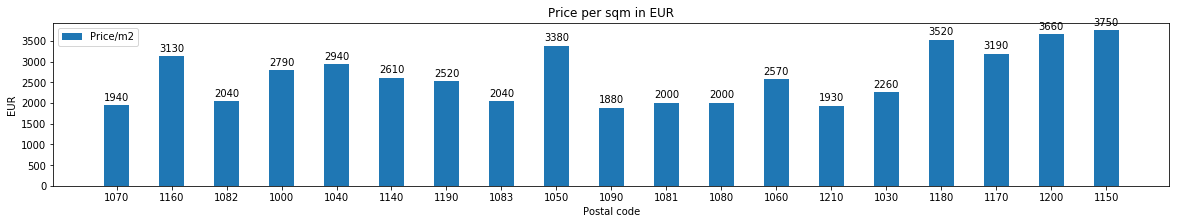

In [26]:
# Some data visualisation of the price indexes by district are shown here for the report section

import matplotlib.pyplot as plt
labels = stations_df['Postal index']
price = stations_df['Price']

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars
plt.rcParams["figure.figsize"] = (20,3)

fig, ax = plt.subplots()
rects1 = ax.bar(x, price, width, label='Price/m2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('EUR')
ax.set_xlabel('Postal code')
ax.set_title('Price per sqm in EUR')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)

#fig.tight_layout()

plt.show()


In [27]:
# I have to find the location of Brussels to visualise the map
address = 'Brussels'

geolocator = Nominatim(user_agent="be_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brussels, Belgium are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brussels, Belgium are 50.8465573, 4.351697.


In [7]:
# create map of Brussels using latitude and longitude values
map_brussels = folium.Map(location=[latitude, longitude], zoom_start=12)

# add Commune markers to map
for lat, lng, label in zip(stations_df['Latitude'], stations_df['Longitude'], stations_df['Commune']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brussels)  
    
map_brussels

Now I have to connect to the Foursquqre to get the data on venues

In [67]:
#Foursquare user login and password (part of the password is hidden)
CLIENT_ID = 'XXXXXXXXXTMYDEX00UHVW2JB5QQO4YXC4TLVYO2BHZ4JG' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXN0W415VATHW4APZNP2KYZPO20JI1UQPYZGJ5OLYT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XXXXXXXXXTMYDEX00UHVW2JB5QQO4YXC4TLVYO2BHZ4JG
CLIENT_SECRET:XXXXXXXXXN0W415VATHW4APZNP2KYZPO20JI1UQPYZGJ5OLYT


In [49]:
#Getting the data from Foursquare system

def getNearbyVenues(names, latitudes, longitudes, radius=2000, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [50]:
# limiting the data extraction to 2 km from the district center and to 100 venues in each district
brux_venues = getNearbyVenues(names=stations_df['Commune'],
                                   latitudes=stations_df['Latitude'],
                                   longitudes=stations_df['Longitude'],
                                   radius=2000, LIMIT=100)

In [51]:
brux_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Anderlecht,50.839098,4.329653,Brasserie Cantillon Brouwerij (Cantillon - Bro...,50.841487,4.335451,Brewery
1,Anderlecht,50.839098,4.329653,Boeremet,50.842882,4.326992,Cocktail Bar
2,Anderlecht,50.839098,4.329653,Pullman Hotel,50.837014,4.335810,Hotel
3,Anderlecht,50.839098,4.329653,Nanobrasserie de l'Ermitage,50.840740,4.337186,Brewery
4,Anderlecht,50.839098,4.329653,Chez Rosario,50.836240,4.331007,Deli / Bodega


In [52]:
print('{} venues are collected'.format(brux_venues.shape[0]))

1885 venues are collected


In [53]:
brux_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Anderlecht,100,100,100,100,100,100
Auderghem,100,100,100,100,100,100
Berchem-Sainte-Agathe,100,100,100,100,100,100
Bruxelles,100,100,100,100,100,100
Etterbeek,100,100,100,100,100,100
Evere,100,100,100,100,100,100
Ganshoren,100,100,100,100,100,100
Ixelles,100,100,100,100,100,100
Jette,100,100,100,100,100,100


In [54]:
print('There are {} uniques categories.'.format(len(brux_venues['Venue Category'].unique())))

There are 215 uniques categories.


# Analyse each district

In [55]:
# one hot encoding
brux_onehot = pd.get_dummies(brux_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brux_onehot['District'] = brux_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [brux_onehot.columns[-1]] + list(brux_onehot.columns[:-1])
brux_onehot = brux_onehot[fixed_columns]

brux_onehot.head()

,District,African Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Bath House,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Spot,Doner Restaurant,Drugstore,Eastern European Restaurant,Electronics Store,Estaminet,Ethiopian Restaurant,Event Service,Event Space,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Friterie,Furniture / Home Store,Garden,Garden Center,Gastropub,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Health Food Store,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lawyer,Lebanese Restaurant,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Molecular Gastronomy Restaurant,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Nightclub,Office,Organic Grocery,Other Nightlife,Other Repair Shop,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Piercing Parlor,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Post Office,Pub,Racetrack,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Trattoria/Osteria,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Anderlecht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Anderlecht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Anderlecht,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [56]:
brux_grouped = brux_onehot.groupby('District').mean().reset_index()
brux_grouped

,District,African Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Bath House,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Spot,Doner Restaurant,Drugstore,Eastern European Restaurant,Electronics Store,Estaminet,Ethiopian Restaurant,Event Service,Event Space,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Friterie,Furniture / Home Store,Garden,Garden Center,Gastropub,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Health Food Store,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lawyer,Lebanese Restaurant,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Molecular Gastronomy Restaurant,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Nightclub,Office,Organic Grocery,Other Nightlife,Other Repair Shop,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Piercing Parlor,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Post Office,Pub,Racetrack,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Trattoria/Osteria,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Anderlecht,0.00,0.00,0.01,0.00,0.00,0.01,0.000000,0.00,0.00,0.01,0.00,0.020000,0.090000,0.00,0.01,0.02,0.00,0.00,0.040000,0.00,0.000000,0.00,0.030000,0.00,0.01,0.00,0.000000,0.01,0.00,0.03,0.00,0.02,0.000000,0.00,0.010000,0.00,0.00,0.00,0.00,0.01,0.000000,0.01,0.00,0.000000,0.01,0.02,0.03,0.00,0.000000,0.01,0.02,0.000000,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.010000,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.010000,0.000000,0.02,0.00,0.000000,0.00,0.000000,0.02,0.00,0.00,0.00,0.00,0.060000,0.00,0.010000,0.01,0.00,0.00,0.010000,0.00,0.000000,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.050000,0.00,0.010000,0.010000,0.00,0.040000,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.020000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.050000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.030000,0.0

In [57]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [58]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most Common Venue'.format(idx+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = brux_grouped['District']

for idx in np.arange(brux_grouped.shape[0]):
    district_venues_sorted.iloc[idx, 1:] = return_most_common_venues(brux_grouped.iloc[idx, :], num_top_venues)
    

In [59]:
district_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anderlecht,Bar,French Restaurant,Hotel,Plaza,Italian Restaurant,Belgian Restaurant,Brewery,Sandwich Place,Bookstore,Coffee Shop
1,Auderghem,French Restaurant,Italian Restaurant,Restaurant,Belgian Restaurant,Park,Brasserie,Salad Place,Thai Restaurant,Fast Food Restaurant,Gym / Fitness Center
2,Berchem-Sainte-Agathe,Supermarket,Bar,Pizza Place,Greek Restaurant,Gym,Clothing Store,Restaurant,Gym / Fitness Center,Brasserie,Chinese Restaurant
3,Bruxelles,Bar,Plaza,Hotel,Coffee Shop,Bookstore,Art Museum,Belgian Restaurant,Seafood Restaurant,Italian Restaurant,Chocolate Shop
4,Etterbeek,Italian Restaurant,Plaza,Bar,Bakery,Park,Restaurant,Coffee Shop,Steakhouse,French Restaurant,Greek Restaurant
5,Evere,Italian Restaurant,Snack Place,Supermarket,Bar,Sandwich Place,Restaurant,Brasserie,Friterie,Bakery,French Restaurant
6,Ganshoren,Bar,Pizza Place,Chinese Restaurant,Greek Restaurant,Supermarket,Italian Restaurant,Gym / Fitness Center,Bakery,Restaurant,French Restaurant
7,Ixelles,Plaza,Coffee Shop,Italian Restaurant,Bar,Hotel,Japanese Restaurant,Bakery,Park,Pizza Place,Tea Room
8,Jette,Bar,Italian Restaurant,Park,Thai Restaurant,Chinese Restaurant,Plaza,Pizza Place,Gym / Fitness Center,Gastropub,French Restaurant
9,Koekelberg,Bar,Plaza,French Restaurant,Seafood Restaurant,Coffee Shop,Belgian Restaurant,Clothing Store,Pizza Place,Sandwich Place,Cocktail Bar


### Performing the K-means clustering

In [60]:

# set number of clusters
kclusters = 5

brux_grouped_clustering = brux_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brux_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 4, 1, 2, 3, 4, 2, 4, 1], dtype=int32)

In [61]:
# add clustering labels
district_venues_sorted.insert(0, 'Clusters', kmeans.labels_)


In [62]:
##### add clustering labels
#district_venues_sorted.insert(0, 'Clusters', kmeans.labels_)
brux_merged=stations_df
brux_merged['District']=brux_merged['Commune']

# add price/m2 for each district
#brux_merged = pd.merge(stations_df1, mean_per_district[['District', 'Price']])

# add latitude/longitude for each district
brux_merged = brux_merged.join(district_venues_sorted.set_index('District'), on='District')

brux_merged.sort_values(by='Clusters', inplace=True)
brux_merged

,Type,Country,Commune,Postal index,Price,Latitude,Longitude,Coordinates,District,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Apartments,Belgium,Woluwe-Saint-Pierre,1150,3750,50.837025,4.427464,"(50.8370253, 4.4274636)",Woluwe-Saint-Pierre,0,Italian Restaurant,French Restaurant,Park,Restaurant,Fast Food Restaurant,Asian Restaurant,Cheese Shop,Ice Cream Shop,Pizza Place,Steakhouse
1,Apartments,Belgium,Auderghem,1160,3130,50.817236,4.426898,"(50.8172355, 4.4268982)",Auderghem,0,French Restaurant,Italian Restaurant,Restaurant,Belgian Restaurant,Park,Brasserie,Salad Place,Thai Restaurant,Fast Food Restaurant,Gym / Fitness Center
16,Apartments,Belgium,Watermael-Boitsfort,1170,3190,50.798106,4.417644,"(50.7981063, 4.4176441)",Watermael-Boitsfort,0,Restaurant,Italian Restaurant,French Restaurant,Park,Bakery,Ice Cream Shop,Stadium,Sandwich Place,Belgian Restaurant,Flower Shop
15,Apartments,Belgium,Uccle,1180,3520,50.803544,4.333844,"(50.8035441, 4.3338445)",Uccle,0,French Restaurant,Italian Restaurant,Park,Bakery,Gastropub,Bar,Bookstore,Furniture / Home Store,Moroccan Restaurant,Cheese Shop
17,Apartments,Belgium,Woluwe-Saint-Lambert,1200,3660,50.843045,4.425673,"(50.8430448, 4.4256732)",Woluwe-Saint-Lambert,0,Italian Restaurant,French Restaurant,Fast Food Restaurant,Park,Restaurant,Asian Restaurant,Cheese Shop,Clothing Store,Sushi Restaurant,Bistro
11,Apartments,Belgium,Molenbeek-Saint-Jean,1080,2000,50.854596,4.338636,"(50.8545959, 4.338636)",Molenbeek-Saint-Jean,1,Bar,Hotel,Plaza,Coffee Shop,Belgian Restaurant,Bookstore,Supermarket,Seafood Restaurant,Italian Restaurant,French Restaurant
10,Apartments,Belgium,Koekelberg,1081,2000,50.860604,4.331550,"(50.8606042, 4.3315503)",Koekelberg,1,Bar,Plaza,French Restaurant,Seafood Restaurant,Coffee Shop,Belgian Restaurant,Clothing Store,Pizza Place,Sandwich Place,Cocktail Bar
0,Apartments,Belgium,Anderlecht,1070,1940,50.839098,4.329653,"(50.8390983, 4.3296526)",Anderlecht,1,Bar,French Restaurant,Hotel,Plaza,Italian Restaurant,Belgian Restaurant,Brewery,Sandwich Place,Bookstore,Coffee Shop
3,Apartments,Belgium,Bruxelles,1000,2790,50.846557,4.351697,"(50.8465573, 4.351697)",Bruxelles,1,Bar,Plaza,Hotel,Coffee Shop,Bookstore,Art Museum,Belgian Restaurant,Seafood Restaurant,Italian Restaurant,Chocolate Shop
8,Apartments,Belgium,Ixelles,1050,3380,50.833114,4.366828,"(50.8331141, 4.3668279)",Ixelles,2,Plaza,Coffee Shop,Italian Restaurant,Bar,Hotel,Japanese Restaurant,Bakery,Park,Pizza Place,Tea Room


In [63]:
# create map with all the clusters and visulasing this on the map of Brussels
map_clusters = folium.Map(location=[50.8465573, 4.351697], zoom_start=12)

# set colors
colors = ['black','blue', 'red','yellow','green']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brux_merged['Latitude'], brux_merged['Longitude'], brux_merged['District'], brux_merged['Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [64]:
#Doing some final analysis on the prices for the conclusion section of the report (min/max/mean prices)
min_price=brux_merged[['District','Price','Postal index','Clusters']]
grouped_single = min_price.groupby('Clusters').agg({'Price': ['mean', 'min', 'max']})
grouped_single

Price            
                 mean   min   max
Clusters                         
0         3450.000000  3130  3750
1         2182.500000  1940  2790
2         2705.000000  1930  3380
3         2463.333333  2260  2610
4         1986.666667  1880  2040